# Soothsinger Modifier Deck Analysis
This is a breakdown of the damage probabilities for a Soothsinger modifier deck using pands, matplotlib, and dask to simulate the deck and collect relevant statistics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gloomhaven import read_deck
from gloomhaven.render import render_tables

In [2]:
deck = read_deck("../decks/Soothsinger.yaml")

In [3]:
attack_data = {}
base_attacks = [1, 2, 3, 4, 5]
samp_size = 10_000

def attacks(samp_size, attack):
    for _ in range(samp_size):
        yield attack

attack_data = {}
for val in base_attacks:
    attack_data[f"base_attack_{val}"] = deck.simulate(attacks(samp_size, val))

attack_data = pd.DataFrame(attack_data)

In [4]:
max_attack = attack_data.max().max()

In [5]:
def get_counts(srs: pd.Series):
    srs = srs.value_counts()
    for attack_val in range(srs.index.max()+1):
        if attack_val not in srs.index:
            srs[attack_val] = 0
    srs = srs / samp_size
    srs.sort_index()
    return srs

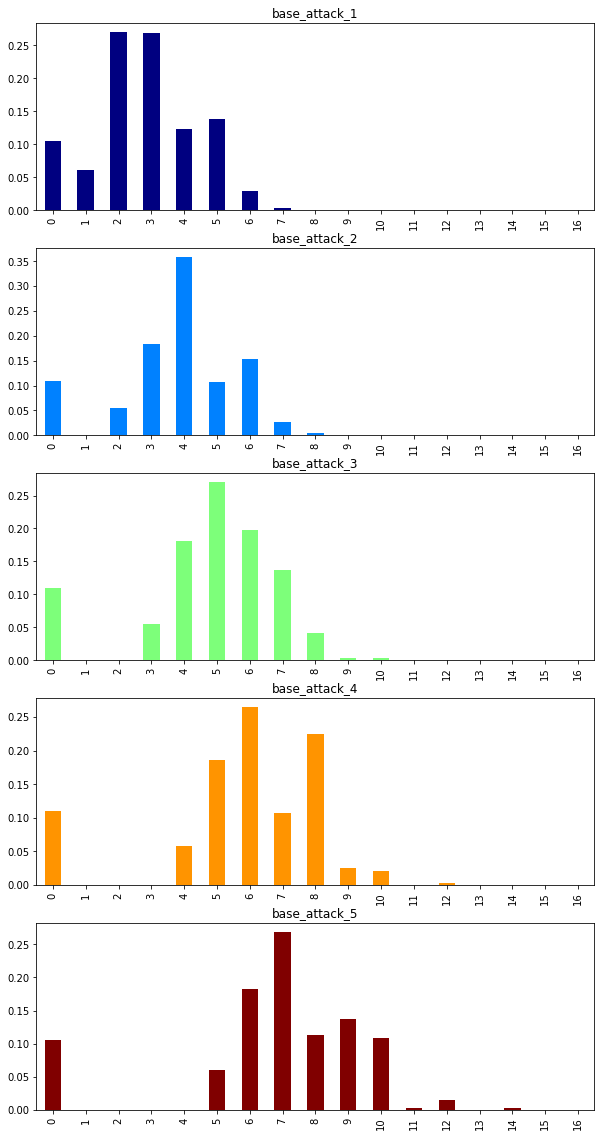

In [6]:
_ = attack_data.apply(get_counts, axis=0) \
    .plot(
        kind="bar",
        subplots=True, 
        figsize=(10,20),
        legend=False,
        colormap="jet",
        sharex=False,
        xticks=[i for i in range(max_attack+1)],
    )
plt.savefig("../assets/pdfs.jpg")

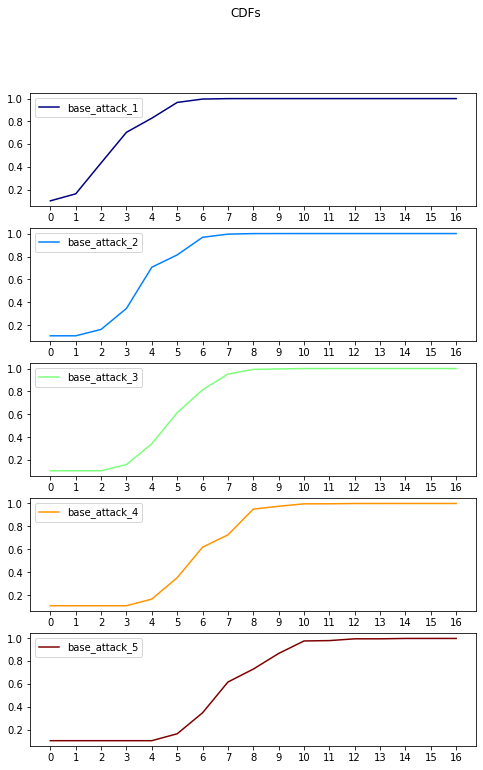

In [7]:
_ = attack_data.apply(get_counts, axis=0) \
    .fillna(0) \
    .cumsum() \
    .plot(
        kind="line",
        subplots=True, 
        figsize=(8, 12),
        colormap="jet",
        sharex=False,
        xticks=[i for i in range(max_attack+1)],
        title="CDFs"
    )

tmp = attack_data.apply(lambda x: x.value_counts(normalize=True), axis=0)
missing = [i for i in range(max(tmp.index)) if i not in tmp.index]
for i in missing:
    tmp.loc[i, :] = None
tmp = tmp.fillna(0).cumsum()
tmp.sort_index(axis=0, inplace=True)
tmp_table = tmp.to_html(classes="table", border=0)

with open("../assets/cdfs.html", "w") as f:
    f.write(render_tables(("CDFs", tmp_table)))

In [8]:
def mode(x):
    return x.value_counts().index[0]

tmp = attack_data.agg(["min", "median", "max", "mean", "std", mode])
tmp_table = tmp.to_html(classes="table", border=0)

with open("../assets/summary_stats.html", "w") as f:
    f.write(render_tables([("Summary Stats", tmp_table)]))

tmp

,base_attack_1,base_attack_2,base_attack_3,base_attack_4,base_attack_5
min,0.000000,0.000000,0.000000,0.000000,0.000000
median,3.000000,4.000000,5.000000,6.000000,7.000000
max,8.000000,10.000000,12.000000,14.000000,16.000000
mean,2.797500,3.785000,4.794300,5.770400,6.783600
std,1.557606,1.779913,2.089599,2.452282,2.794951
mode,2.000000,4.000000,5.000000,6.000000,7.000000
